## Code to generate puzzles

In [21]:
import numpy as np
import pickle
import random
import networkx as nx
import matplotlib.pyplot as plt
import os
import json

Function to sample a Gaussian n in the range [1, M]

In [22]:
# Function to sample a Gaussian n in the range [1, M]
M = 10
def sample_gaussian_n(min_n=1, max_n=10, mean=None, std_dev=None):
    if(mean==None):
        mean = M/2
    if (std_dev == None):
        std_dev = M/4
    n = int(np.clip(np.random.normal(mean, std_dev), min_n, max_n))
    return n

Function to load the flat dataset

In [23]:
# Function to load the flat dataset
def load_flat_dataset(file_path='../data/NIS/NISdb_flat.pkl'):
    with open(file_path, 'rb') as f:
        flat_dataset = pickle.load(f)
    return flat_dataset

Function to Sample a random string of size n from NISdb_flat

In [24]:
# Function to Sample a random string of size n from NISdb_flat
def sample_random_string(n, file_path='../data/NIS/NISdb_flat.pkl'):
    flat_dataset = load_flat_dataset(file_path)
    
    if n not in flat_dataset or not flat_dataset[n]:
        raise ValueError(f"No strings of length {n} found in the dataset.")
    
    return random.choice(flat_dataset[n])

Function to create transitions

Sample two numbers (exponental) between 1 to min(2n,M) p and q, sample strings of size p and q from NISdb_flat

In [25]:
# Function to create transitions
def create_transition(n, file_path='../data/NIS/NISdb_flat.pkl'):
    Max_size = min(2*n, M)
    while True:
        p = int(np.clip(np.random.exponential(scale=n), 1, Max_size))
        q = int(np.clip(np.random.exponential(scale=n), 1, Max_size))
        
        s1 = sample_random_string(p, file_path)
        s2 = sample_random_string(q, file_path)
        
        if s1 != s2:
            break
        
    
    return [s1, s2]

Function to create an array of transitions of size t for a given n

In [26]:
# Transitions are arrays of size 2 of strings
# Function to create an array of transitions of size t for a given n
def create_transitions_array(n, t, file_path='../data/NIS/NISdb_flat.pkl'):
    transitions = []
    for _ in range(t):
        transitions.append(create_transition(n, file_path))
    return transitions

Function to apply a transition [s1, s2] to a string s

In [27]:
# To apply a transition [s1, s2] to a string s, we find the first occurrence of s1 in s and replace it with s2:

# Function to apply a transition [s1, s2] to a string s
def apply_transition(s, transition):
    s1, s2 = transition
    if s1 not in s:
        return None
    return s.replace(s1, s2, 1)

Graph generator
1. Sample n
2. Create t transitions (t =5) 
3. Create a graph with root node as a string of size n and t transitions upto depth d

Graph generator function

In [28]:
# Graph generator function
def generate_graph(n = sample_gaussian_n(), t=3, d=3, file_path='../data/NIS/NISdb_flat.pkl'):        
    root = sample_random_string(n, file_path)
    # print(f"Random string of length {n}: {root}")
    transitions = create_transitions_array(n, t, file_path)
    # print(f"Transitions array: {transitions}")
    
    G = nx.DiGraph()
    G.add_node((-1, -1, -1), string=root)
    current_level = [((-1, -1, -1), root)]
    
    for depth in range(d):
        next_level = []
        for node, node_string in current_level:
            for i, transition in enumerate(transitions):
                new_node_string = apply_transition(node_string, transition)
                if new_node_string is not None:
                    new_node = tuple(list(node[:depth]) + [i] + [-1] * (2 - depth))
                    G.add_node(new_node, string=new_node_string)
                    G.add_edge(node, new_node, label=f"{transition[0]} -> {transition[1]}")
                    next_level.append((new_node, new_node_string))
        current_level = next_level
    
    return G

In [29]:
# Function to plot the graph
def plot_graph(G):
    pos = nx.shell_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'string'), node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrows=True)
    
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.show()

Generated graph: DiGraph with 364 nodes and 363 edges


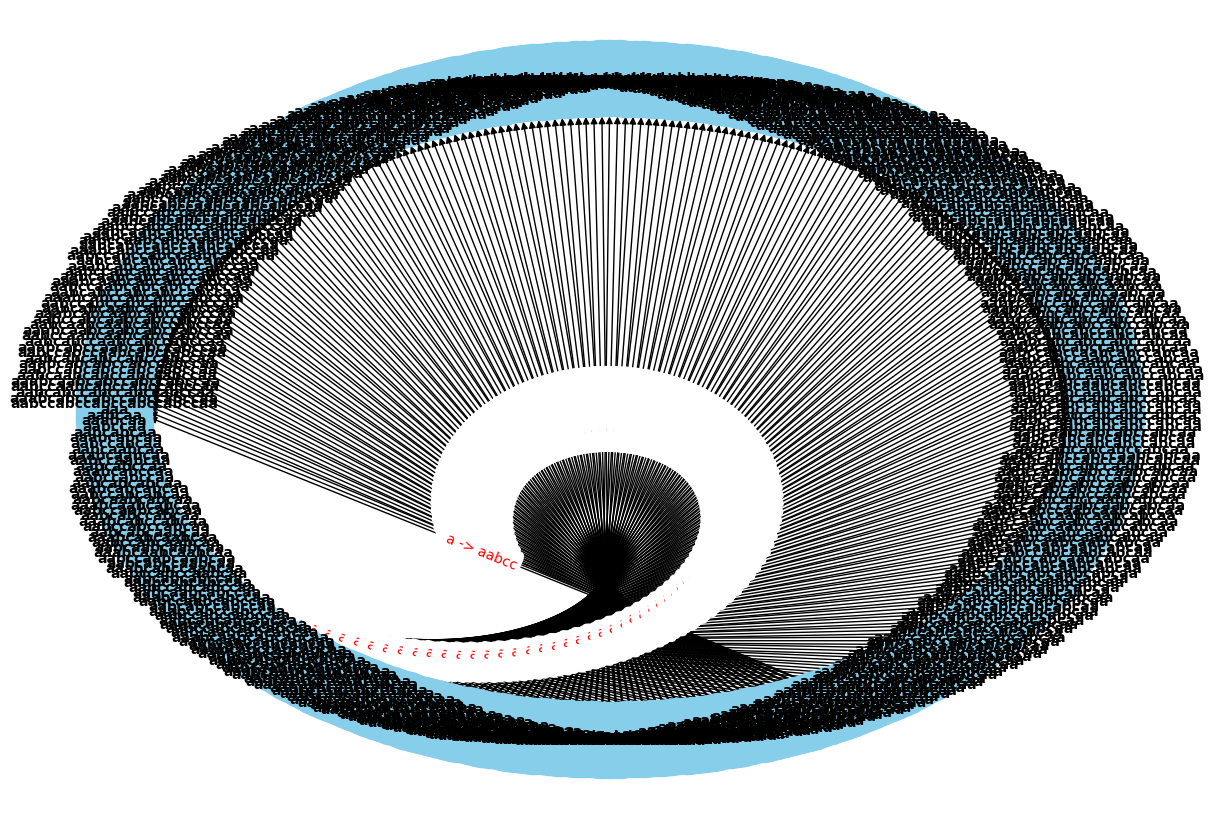

In [32]:
# Example usage
if __name__ == "__main__":    
    graph = generate_graph(3,3,5)
    print(f"Generated graph: {graph}")
    
    plot_graph(graph)